In [1]:
import tensorflow as tf
import os
print(tf.__version__)

2.0.0


In [2]:
data_dir = './datasets'
train_cats_dir = data_dir + '/train/cats/'
train_dogs_dir = data_dir + '/train/dogs/'
test_cats_dir = data_dir + '/valid/cats/'
test_dogs_dir = data_dir + '/valid/dogs/'


In [3]:
len(os.listdir(train_cats_dir))

11500

In [4]:
# 构建训练数据集
train_cat_filenames = tf.constant([train_cats_dir + filename for filename in os.listdir(train_cats_dir)])
train_dog_filenames = tf.constant([train_dogs_dir + filename for filename in os.listdir(train_dogs_dir)])
train_filenames = tf.concat([train_cat_filenames, train_dog_filenames], axis=-1)

# cat 0  dog :1
train_labels = tf.concat([
    tf.zeros(train_cat_filenames.shape, dtype=tf.int32), 
    tf.ones(train_dog_filenames.shape, dtype=tf.int32)], 
    axis=-1)


In [5]:
train_filenames

<tf.Tensor: id=3, shape=(23000,), dtype=string, numpy=
array([b'./datasets/train/cats/cat.0.jpg',
       b'./datasets/train/cats/cat.1.jpg',
       b'./datasets/train/cats/cat.10.jpg', ...,
       b'./datasets/train/dogs/dog.9997.jpg',
       b'./datasets/train/dogs/dog.9998.jpg',
       b'./datasets/train/dogs/dog.9999.jpg'], dtype=object)>

In [6]:
train_labels

<tf.Tensor: id=11, shape=(23000,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 1, 1])>

In [7]:
def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)            # 读取原始文件
    image_decoded = tf.image.decode_jpeg(image_string)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [256, 256]) / 255.0
    return image_resized, label

In [8]:
img,label = _decode_and_resize(tf.constant('./datasets/train/cats/cat.0.jpg'),tf.constant(0))

In [9]:
import matplotlib.pyplot as plt

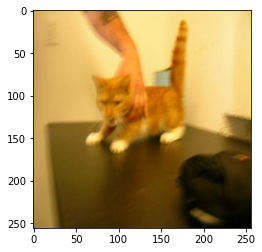

In [10]:
plt.imshow(img.numpy())

In [11]:
#构建训练集

def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)            # 读取原始文件
    image_decoded = tf.image.decode_jpeg(image_string)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [256, 256]) / 255.0
    return image_resized, label


batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
#名字
train_dataset = train_dataset.map(
    map_func=_decode_and_resize, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE)



In [12]:
for img,label in train_dataset.take(1):
    print(img,label)

tf.Tensor(
[[[0.7940257  0.64108455 0.3391238 ]
  [0.80168504 0.64874387 0.3467831 ]
  [0.8132659  0.66032475 0.35836396]
  ...
  [0.9532872  0.7964244  0.46309108]
  [0.9428615  0.7938419  0.47619486]
  [0.9352022  0.7861826  0.46853554]]

 [[0.7940257  0.64108455 0.3391238 ]
  [0.80168504 0.64874387 0.3467831 ]
  [0.8132659  0.66032475 0.35836396]
  ...
  [0.95611584 0.7992531  0.46591976]
  [0.9428615  0.7938419  0.47619486]
  [0.9352022  0.7861826  0.46853554]]

 [[0.7940257  0.64108455 0.3391238 ]
  [0.80168504 0.64874387 0.3467831 ]
  [0.8132659  0.66032475 0.35836396]
  ...
  [0.95626533 0.7985458  0.4725622 ]
  [0.94678307 0.79776347 0.48011643]
  [0.93912375 0.79010415 0.4724571 ]]

 ...

 [[0.60059744 0.4790288  0.2162837 ]
  [0.60228246 0.48071384 0.21796875]
  [0.6060202  0.4844516  0.2217065 ]
  ...
  [0.00784314 0.01176471 0.        ]
  [0.00784314 0.01176471 0.        ]
  [0.00784314 0.01176471 0.        ]]

 [[0.59486824 0.47329962 0.21055454]
  [0.5987898  0.4772212  0

In [13]:

# 取出前buffer_size个数据放入buffer，并从其中随机采样，采样后的数据用后续数据替换
train_dataset = train_dataset.shuffle(buffer_size=23000)    

train_dataset = train_dataset.repeat(count=3)

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [14]:
# 构建测试数据集
test_cat_filenames = tf.constant([test_cats_dir + filename for filename in os.listdir(test_cats_dir)])
test_dog_filenames = tf.constant([test_dogs_dir + filename for filename in os.listdir(test_dogs_dir)])
test_filenames = tf.concat([test_cat_filenames, test_dog_filenames], axis=-1)
test_labels = tf.concat([
    tf.zeros(test_cat_filenames.shape, dtype=tf.int32), 
    tf.ones(test_dog_filenames.shape, dtype=tf.int32)], 
    axis=-1)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.map(_decode_and_resize)
test_dataset = test_dataset.batch(batch_size)

In [15]:

class CNNModel(tf.keras.models.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = tf.keras.layers.Conv2D(32, 5, activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(64, activation='relu')
        self.d2 = tf.keras.layers.Dense(2, activation='softmax') #sigmoid 和softmax

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)       
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

# softmax CategoricalCrossentropy
#sigmoid tf.keras.losses.BinaryCrossentropy

In [16]:
learning_rate = 0.001
model = CNNModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
#label 没有one-hot


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)



In [17]:
EPOCHS=10
for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_dataset:
        train_step(images, labels)

    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100
                         ))


Epoch 1, Loss: 0.6417950987815857, Accuracy: 63.08551025390625, Test Loss: 0.5889803767204285, Test Accuracy: 69.9000015258789
Epoch 2, Loss: 0.24451398849487305, Accuracy: 89.40289306640625, Test Loss: 1.4253844022750854, Test Accuracy: 67.6500015258789
Epoch 3, Loss: 0.02805589698255062, Accuracy: 99.26522064208984, Test Loss: 1.8774255514144897, Test Accuracy: 66.8499984741211
Epoch 4, Loss: 0.008574907667934895, Accuracy: 99.78260803222656, Test Loss: 2.507993459701538, Test Accuracy: 65.1500015258789
Epoch 5, Loss: 0.015207703225314617, Accuracy: 99.56666564941406, Test Loss: 2.698625087738037, Test Accuracy: 66.5999984741211
Epoch 7, Loss: 0.0011095069348812103, Accuracy: 99.97246551513672, Test Loss: 2.841193914413452, Test Accuracy: 67.69999694824219
Epoch 8, Loss: 0.00020378465706016868, Accuracy: 99.99565124511719, Test Loss: 3.0265300273895264, Test Accuracy: 67.69999694824219
Epoch 9, Loss: 0.014189650304615498, Accuracy: 99.613037109375, Test Loss: 2.6684014797210693, Test

In [ ]:
#batch  64 128 
